# Dropout


### **Prerequisites**
* Regularization

***What will we cover in this notebook?***

* Explaining dropout mathematically and intuitively in neural networks
* Implementation in PyTorch
* Showing the difference between non-dropout and dropout models
* Reviewing some key points
-----

### 1. What is Dropout?


**A brief introduction**

A common problem in machine learning is how to increase our model's performance on unseen data. We want to reduce the test error. To achieve this goal, we apply some regularization strategies. Regularization is defined as "any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error". We'll focus on dropout which is one of those strategies !

We basically remove (drop out) some neurons in our original network with some probability. You can assume that we shut down some parts of the neural network during every training example and get different models for each one.

We don't drop out any of neurons during testing. Because we don't want our output to be a random value. In theory, one thing we could do is drop out some neurons in testing part then take the average of each model. But it will be computationally inefficient!


![before_d.png](images/before_d.png)

![after_d.png](images/after_d.png)

**What is the idea behind 'Dropout'?**

The basic idea of the dropout in neural networks is to prevent overfitting. Sometimes, one part of the networks has large weights and it ends up dominating all the training while the other part of the network doesn't get trained well. We simply turns off some nodes and say, don't pass through here. With this process, we give chance other weak nodes to train as well as the other powerfull ones.

We apply this process by giving the algorithm a parameter. This parameter is the probability that each node gets dropped at a particular epoch.

![drop.gif](images/drop.gif)

*https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a*

### 2. Similarity between dropout and ensembles methods


Bagging (short for bootstrap aggregating) is a technique for reducing generalization error by combining several models. The idea is to train several different models separately, then have all of the models vote on the
output for test examples. This is an example of a general strategy in machine learning called model averaging. 

Techniques employing this strategy are known as ensemble methods.
The reason that model averaging works is that different models will usually
not make all the same errors on the test set.

Dropout can be thought of as a method of making bagging practical for ensembles
of very many large neural networks.

Dropout training is not quite the same as bagging training. 

* In the case of bagging, the models are all independent. 

* In the case of dropout, the models share parameters, with each model inheriting a different subset of parameters from the parent neural network. This parameter sharing makes it possible to represent an exponential number of models with a tractable amount of memory.

* In the case of bagging, each model is trained to convergence on its respective training set. 
* In the case of dropout, typically most models are not explicitly trained at all—usually, the model is large enough that it would be infeasible to sample all possible subnetworks within the lifetime of the universe.

Beyond these differences, dropout follows the bagging algorithm. For
example, the training set encountered by each sub-network is indeed a subset of
the original training set sampled with replacement.

![ensemble_example.PNG](images/ensemble_example.png)

### 3. Implementation in PyTorch on a basic neural network 

In this section, we'll explain how we apply dropout in theory and in PyTorch together.

We said that, we set a probability of eliminating a node in the network during training. We do this by creating a mask for each layer. This mask is a binary vector which is 

In [1]:
import torch
import torch.nn as nn

def dropout_layer(X, p):
    assert 0 <= p <= 1
    # In this case, all elements are dropped out
    if p == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if p == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > p).float()
    return mask * X / (1.0 - p)

To try the implementation, run the cell below:

In [2]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('Our input vector X:\n',X)
print('If we set probability to 0 and keep every node in the network:\n', dropout_layer(X, 0.))
print('If we set probability to 0.5 and make half of the nodes "0":\n', dropout_layer(X, 0.5))
print('If we set probability to 1 and drop out every node:\n', dropout_layer(X, 1.))

Our input vector X:
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
If we set probability to 0 and keep every node in the network:
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
If we set probability to 0.5 and make half of the nodes "0":
 tensor([[ 0.,  2.,  4.,  0.,  0.,  0., 12.,  0.],
        [ 0.,  0., 20.,  0.,  0., 26.,  0.,  0.]])
If we set probability to 1 and drop out every node:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


* We'll do an implementation with MNIST dataset which is a very popular data and contains 77.000 handwritten digits. Every data points has 28x28 grayscale image and a label (the digit) from 0 to 9. We'll cover non-dropout and dropout models together. Let's do  it!
* Load and prepare the dataset


In [3]:
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

* To print some example images from our dataset, run the cell above:

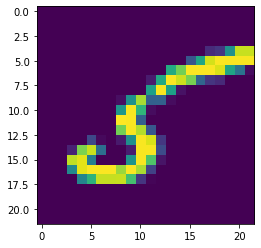

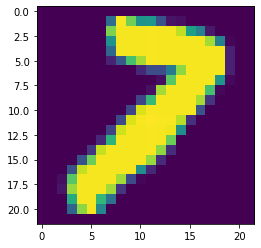

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, 300)][0]    # get the first example
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, 300)][0]    # get the first example
plt.imshow(x[0].numpy())
plt.show()

* Now, we'll seperate our training dataset into training and validation sets.

In [5]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

* Pass datasets to Pytorch dataloader:

In [6]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

* It's time to create dropout model !

In [7]:
import torch.nn.functional as F
# import torch.nn as nn


class NeuralNetworkClass(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.layer1 = torch.nn.Linear(crop_size*crop_size, 225)
        self.layer2 = torch.nn.Linear(225, 100)
        self.layer3 = torch.nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.softmax(x, dim=1)
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params


# set probability that the neuron activation will be set to zero (it will be dropped out !)
dropout1, dropout2 = 0.1, 0.5

# This is our dropout implementation !
class NeuralNetworkClassDropout(torch.nn.Module):
    def __init__(self, is_training = True):
        super().__init__()    # initialise parent module
        self.layer1 = torch.nn.Linear(crop_size*crop_size, 225)
        self.layer2 = torch.nn.Linear(225, 100)
        self.layer3 = torch.nn.Linear(100, 10)
        self.training = is_training

        
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.layer1(x)
        x = F.relu(x)
        if self.training == True:
            x = dropout_layer(x, dropout1)    # apply first dropout after the first layer
        x = self.layer2(x)
        x = F.relu(x)
        if self.training == True:
            x = dropout_layer(x, dropout2)    # apply second dropout after the second layer
        x = self.layer3(x)
        x = F.softmax(x, dim=1)
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params


In [8]:
learning_rate = 0.0005
myNeuralNetwork = NeuralNetworkClass()
print('Number of parameters in non-dropout model:', get_n_params(myNeuralNetwork))
myNeuralNetworkDropout = NeuralNetworkClassDropout()
print('Number of parameters in dropout model:', get_n_params(myNeuralNetworkDropout))


# CREATE OUR CRITERION
criterion = torch.nn.CrossEntropyLoss()             # callable class that compares our predictions to our labels and returns our loss

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer_nond = SummaryWriter(log_dir="runs/nondropout")          # we will use this to show our models performance on a graph
writer_d = SummaryWriter(log_dir="runs/dropout")

Number of parameters in non-dropout model: 132735
Number of parameters in dropout model: 132735


* Training part:

We assign "p" to represent the probability of a neuron, in the hidden layer, being excluded from the network; this probability value is usually equal to 0.5. We do the same process for the input layer whose probability value is usually lower than 0.5 (e.g. 0.1). Remember, we delete the connections going into, and out of, the neuron when we drop it.

Non-Dropout Model's Loss
Epoch: 1 	Training Loss: 219.41548706991287 	Validation Loss: 199.16237215452557
Epoch: 2 	Training Loss: 198.75034081539533 	Validation Loss: 195.91136913058125
Epoch: 3 	Training Loss: 196.61333351427942 	Validation Loss: 194.3119941421702
Epoch: 4 	Training Loss: 195.2834820320539 	Validation Loss: 193.23027622850634
Epoch: 5 	Training Loss: 194.30112537764526 	Validation Loss: 192.148443632488
Epoch: 6 	Training Loss: 193.58151158286483 	Validation Loss: 191.4909903610809
Epoch: 7 	Training Loss: 192.89192310928385 	Validation Loss: 190.8841262527659
Epoch: 8 	Training Loss: 192.37266669797776 	Validation Loss: 190.40712849097915
Epoch: 9 	Training Loss: 191.9479674805156 	Validation Loss: 189.97937076906615
Epoch: 10 	Training Loss: 191.55717700948495 	Validation Loss: 189.70237137999715


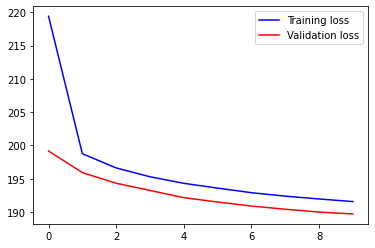

Dropout Model's Loss
Epoch: 1 	Training Loss: 229.1228849601258 	Validation Loss: 208.11589219298543
Epoch: 2 	Training Loss: 207.34049301927962 	Validation Loss: 205.50284149073346
Epoch: 3 	Training Loss: 205.68640097693714 	Validation Loss: 202.92597391635556
Epoch: 4 	Training Loss: 195.34906430744454 	Validation Loss: 192.53642287435412
Epoch: 5 	Training Loss: 193.6698768059616 	Validation Loss: 191.42777648153185
Epoch: 6 	Training Loss: 192.87559752208193 	Validation Loss: 190.70096168035192
Epoch: 7 	Training Loss: 192.23136846244793 	Validation Loss: 190.24102763888203
Epoch: 8 	Training Loss: 191.7708025978654 	Validation Loss: 189.6186132793185
Epoch: 9 	Training Loss: 191.34948861690432 	Validation Loss: 189.39557613903963
Epoch: 10 	Training Loss: 191.0238081110103 	Validation Loss: 189.02937056143074


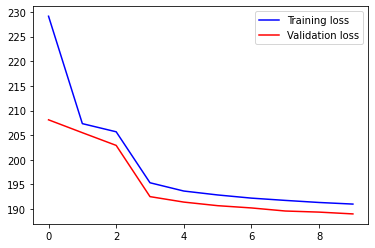

In [9]:
import matplotlib.pyplot as plt

# TRAINING LOOP
def train(model, epochs, writer, verbose=True):
    model.train()                                  # put the model into training mode (more on this later)
    losses_train = []
    losses_val = []
    for epoch in range(epochs):
        running_loss_train = 0.0
        for idx, minibatch in enumerate(train_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            # CREATE OUR OPTIMISER
            optimiser = torch.optim.Adam(          # what optimiser should we use?
            model.parameters(),                    # what should it optimise?
            lr=learning_rate                       # using what learning rate?
            )
            optimiser.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser.step()                       # update the model's parameters
            writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
            running_loss_train += loss.item() * inputs.size(0)

        model.eval()
        running_loss_val = 0.0
        for idx, minibatch in enumerate(val_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            # CREATE OUR OPTIMISER
            optimiser = torch.optim.Adam(          # what optimiser should we use?
            model.parameters(),                    # what should it optimise?
            lr=learning_rate                       # using what learning rate?
            )
            optimiser.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser.step()                       # update the model's parameters
            writer.add_scalar('Loss/Validation', loss, epoch*len(val_loader) + idx)    # write loss to a graph
            running_loss_val += loss.item() * inputs.size(0)

        epoch_loss_train = running_loss_train / len(train_loader)
        losses_train.append(epoch_loss_train)

        epoch_loss_val = running_loss_val / len(val_loader)
        losses_val.append(epoch_loss_val)

        print('Epoch:', epoch+1, '\tTraining Loss:', epoch_loss_train, '\tValidation Loss:', epoch_loss_val)

    plt.plot(losses_train,'b-', label='Training loss')
    plt.plot(losses_val, 'r-', label='Validation loss')
    plt.legend()
    plt.show()


print("Non-Dropout Model's Loss")
train(myNeuralNetwork, 10, writer=writer_nond)
print("Dropout Model's Loss")           
train(myNeuralNetworkDropout, 10, writer=writer_d)

* Evaluate our two models:

In [12]:
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)              # test DATA not test LOADER
    for inputs, labels in dataloader:                   # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

print("Non-Dropout Model's Evaluation:")
print('Train Accuracy:', calc_accuracy(myNeuralNetwork, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetwork, val_loader))
print('Test Accuracy:', calc_accuracy(myNeuralNetwork, test_loader))

print("\nDropout Model's Evaluation:")
print('Train Accuracy:', calc_accuracy(myNeuralNetworkDropout, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetworkDropout, val_loader))
print('Test Accuracy:', calc_accuracy(myNeuralNetworkDropout, test_loader))


Non-Dropout Model's Evaluation:
Train Accuracy: 96.59
Validation Accuracy: 96.77
Test Accuracy: 52.42

Dropout Model's Evaluation:
Train Accuracy: 96.95
Validation Accuracy: 97.22
Test Accuracy: 53.04


### 4. Visualizing the difference between a non-dropout and dropout implemented nn


![diff.png](images/diff.png)

As we see above, our model's loss curves are converged. They perform very good on training data, but it is poor on test data. So that means, we have an overfitting problem.

We tried a dropout model and saw that test accuracy increased.

* Non-Dropout Model Test Accuracy: 52.42
* Dropout Model Test Accuracy: 53.04

**What to do while testing?**



### 5. Summary

* Dropout means turning off some neurons in our network with some probability.
* Dropout helps us to prevent overfitting.
* Dropout follows the bagging algorithm. The training set encountered by each sub-network is indeed a subset of the original training set sampled with replacement. This is the similarity between ensemble models and dropout method.
* Dropout is only used during training.


### 6. What to do next?
* Try to change the dropout parameters and see its effect on training loss and accuracy
* Try to combine dropout with other regularization methods and compare model's performances
* What is the ideal dropout probability rate for different layers? How to choose it? Do some research on the internet, check out the papers and articles.